In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # lambda arguments: expression. lambda 可接受多个参数，但只能有一个表达式。
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 14.304770469665527


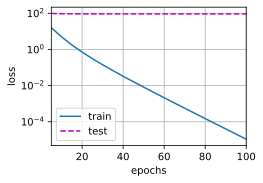

In [6]:
train(lambd=0)

w的L2范数是： 0.35842767357826233


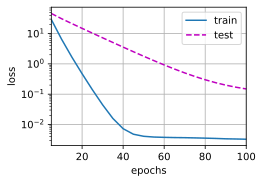

In [7]:
train(lambd=3)

In [8]:
# 简洁实现

def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')  # no reduction means no sum or mean
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

这段代码定义了一个简洁版本的线性回归模型训练过程，使用了 PyTorch 的高级 API。下面是逐行的解释：

1. `def train_concise(wd):`

   定义一个名为 `train_concise` 的函数，接受一个参数 `wd`，这是权重衰减（也称为 L2 正则化）的系数。

2. `net = nn.Sequential(nn.Linear(num_inputs, 1))`

   创建一个神经网络模型 `net`，它由一个线性层组成，该层接受 `num_inputs` 个输入特征，并产生一个输出。

3. `for param in net.parameters(): param.data.normal_()`

   遍历模型的所有可训练参数，并对它们进行初始化。这里使用的是正态分布初始化方法 `normal_()`。

4. `loss = nn.MSELoss(reduction='none')`

   创建一个均方误差损失函数 `loss` 实例，其中 `reduction='none'` 表示不执行任何减少操作，即不平均或求和损失值。

5. `num_epochs, lr = 100, 0.003`

   定义训练轮数 `num_epochs` 为 100 轮，学习率 `lr` 为 0.003。

6. `trainer = torch.optim.SGD([{"params":net[0].weight,'weight_decay': wd}, {"params":net[0].bias}], lr=lr)`

   创建一个 SGD（随机梯度下降）优化器实例 `trainer`。优化器配置了两个参数组：
   - 第一组是线性层的权重参数 `net[0].weight`，并且设置了权重衰减系数 `weight_decay` 为 `wd`。
   - 第二组是线性层的偏置参数 `net[0].bias`，权重衰减系数默认为 0（即不进行权重衰减）。

7. `animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])`

   创建一个动画绘制器实例 `animator`，用于可视化训练和测试损失随训练轮数的变化情况。这里设置了横坐标为训练轮数，纵坐标为损失值（对数尺度），并且只从第 5 轮开始绘制。

8. `for epoch in range(num_epochs):`

   开始训练循环，遍历 `num_epochs` 次。

9. `for X, y in train_iter:`

   对于每一轮训练，遍历训练数据集 `train_iter` 中的每个批次。

10. `trainer.zero_grad()`

    清除优化器中梯度缓存。

11. `l = loss(net(X), y)`

    计算当前批次的预测值与实际标签之间的损失。

12. `l.mean().backward()`

    计算损失的平均值，并反向传播计算梯度。

13. `trainer.step()`

    根据计算出的梯度更新模型参数。

14. `if (epoch + 1) % 5 == 0:`

    如果当前轮数是 5 的倍数，进行以下操作。

15. `animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))`

    将当前轮次的训练损失和测试损失添加到动画绘制器中，以便绘图。

16. `print('w的L2范数：', net[0].weight.norm().item())`

    打印最终训练完成后线性层权重的 L2 范数。

这段代码的主要目的是训练一个带有权重衰减的简单线性回归模型，并可视化训练和测试损失的变化。权重衰减有助于防止过拟合，并且通过调整 `wd` 参数可以控制正则化的强度。

w的L2范数： 13.280887603759766


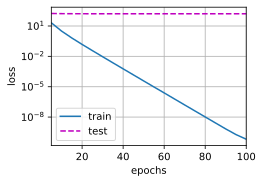

In [9]:
train_concise(0)

w的L2范数： 0.34106066823005676


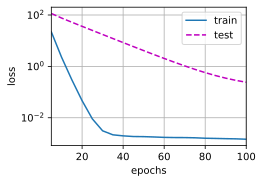

In [10]:
train_concise(3)